In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import copy
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.ticker as mticker
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive





# Read data chunks




In [ ]:
import pickle

# Load the list of dataframes from disk
with open('/content/drive/MyDrive/Covid files/df_symptoms_chunks_data.pkl', 'rb') as f:
# with open('/content/drive/MyDrive/Covid files/df_symptoms_chunks_data_month with_previous2.pkl', 'rb') as f:
# with open('/content/drive/MyDrive/Covid files/df_symptoms_chunks_data_2weeks.pkl', 'rb') as f:
# with open('/content/drive/MyDrive/Covid files/df_symptoms_chunks_data_1month.pkl', 'rb') as f:

    df_list = pickle.load(f)


In [ ]:
y_df = pd.read_csv('/content/drive/MyDrive/Covid files/y_df.csv')
y_df

# Encode the 'class' column as integers
le = LabelEncoder()
y_df = le.fit_transform(y_df)

# Convert the target variable to integers
y_df = y_df.astype(int)


y_df_list = []
c=0
for i in range(len(df_list)):
  yy = y_df[c:c+len(df_list[i])]
  y_df_list.append(yy)
  c+=len(df_list[i])



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# XGBoost classifier



In [ ]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
from scipy import sparse

def train_xgboost(df_list,y_df_list,fs_masks=None,retrain=False):
  booster = None
  acc=[]
  f1s=[]
  precisions =[]
  recalls=[]
  aucs=[]
  y_pred = []
  y_true = []
  results=[]
  for i in range(len(df_list)):
    if retrain:
      booster = None
    # Define your data and masks
    X = df_list[i].values
    # Define your labels
    y = y_df_list[i]
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    if fs_masks != None :
      masks_train = [fs_masks[i]]*len(X_train)
      masks_val = [fs_masks[i]]*len(X_val)
      masks_test = [fs_masks[i]]*len(X_test)


      # Apply masks to input data
      X_train_masked = X_train * masks_train
      X_val_masked = X_val * masks_val
      X_test_masked = X_test * masks_test
    else:
      X_train_masked = X_train
      X_val_masked = X_val
      X_test_masked = X_test


    # Convert masked data to sparse matrix
    X_train_sparse = sparse.csr_matrix(X_train_masked)
    X_val_sparse = sparse.csr_matrix(X_val_masked)
    X_test_sparse = sparse.csr_matrix(X_test_masked)



    # eval_set = [(X_train, y_train), (X_val, y_val)]
    # eval_metric = ["mlogloss",'merror']
    dtrain = xgb.DMatrix(X_train_sparse, label=y_train)
    dval = xgb.DMatrix(X_val_sparse, label=y_val)
    dtest = xgb.DMatrix(X_test_sparse)
    params = {'objective': 'multi:softmax', 'max_depth': 3,'num_class': 4,"eval_metric": ['merror']}
    evals_result = {}
    # Train XGBoost model on masked data
    booster = xgb.train(params, dtrain, xgb_model=booster,evals=[(dtrain,'train'),(dval,'val')], verbose_eval=False,evals_result=evals_result)
    # print(booster.get_score(importance_type='gain'))

    # Make predictions on masked test data
    preds = booster.predict(dtest)
    y_pred.append(preds)
    y_true.append(y_test)
    print(len(y_true))

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, preds)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    acc.append(accuracy)
    print(np.mean(acc))

    # Calculate F1 score
    f1 = f1_score(y_test, preds, average='weighted')
    f1s.append(f1)

    # Calculate precision
    precision = precision_score(y_test, preds, average='weighted')
    precisions.append(precision)

    # Calculate recall
    recall = recall_score(y_test, preds, average='weighted')
    recalls.append(recall)

    # Calculate AUC

    # Binarize the true labels
    y_true_binarized = label_binarize(y_test, classes=np.unique(y_test))

    # Calculate AUC for each class
    try:
      n_classes = len(np.unique(y_test))
      auc_scores = []

      for j in range(n_classes):
          y_true_j = y_true_binarized[:, j]     # True labels for class i
          y_pred_j = (preds == j).astype(int)  # Predicted labels for class i
          auc_j = roc_auc_score(y_true_j, y_pred_j)
          wighted_auc_j = ((preds==j).sum()/len(preds)) * auc_j
          auc_scores.append(auc_j)

      # Average the AUC scores
      mean_auc = np.mean(auc_scores)
      aucs.append(mean_auc)
    except:
      print('### AUC EXCEPTION ###')
      aucs.append(0.5)


    epochs = len(evals_result['train']['merror'])
    x_axis = range(0, epochs)

    # fig, ax = plt.subplots()
    # ax.plot(x_axis, np.array([1] * epochs) -np.array(evals_result['train']['merror']), label='Train')
    # ax.plot(x_axis, np.array([1] * epochs)-np.array(evals_result['val']['merror']), label='valid')
    # ax.legend()
    # plt.xlabel('epoch')
    # plt.ylabel('ACC')
    # plt.title(f'XGBoost Accuracy chunk {i+1}')
    # # plt.savefig(f'ss {i+1}.jpg')
    # plt.show()
    results.append((np.array([1] * epochs) -np.array(evals_result['train']['merror']),np.array([1] * epochs)-np.array(evals_result['val']['merror'])))
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Masking
tf.random.set_seed(1)

def train_mlp(df_list, y_df_list, fs_masks=None,retrain=False):
    acc = []
    f1s=[]
    precisions =[]
    recalls=[]
    aucs=[]
    # Create logistic regression model
    model = Sequential()
    model.add(Masking(mask_value=-1, input_shape=(df_list[0].shape[1],)))
    model.add(Dense(64, activation='relu'))
    # input_dim is the number of features in your data
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # num_classes is the number of classes in your classification problem
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = model
    # MLPClassifier(
    #       activation="relu",
    #       max_iter=100,
    #       validation_fraction=0.2,
    #       early_stopping=True,
    #       random_state=42,verbose=True)
    results = []
    y_pred = []
    y_true = []
    for i in range(len(df_list)):
        if retrain:
          # Create logistic regression model
          model = Sequential()
          model.add(Masking(mask_value=-1, input_shape=(df_list[0].shape[1],)))
          model.add(Dense(64, activation='relu'))
          # input_dim is the number of features in your data
          model.add(Dense(32, activation='relu'))
          model.add(Dense(4, activation='softmax'))
          # num_classes is the number of classes in your classification problem
          model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          classifier = model


        # Define your data and masks
        X = df_list[i].values
        # Define your labels
        y = y_df_list[i]
        if fs_masks is not None:
          print(X)
          X = np.where(np.array(fs_masks[i]) == 0, -1, X)
          print(fs_masks[i])
          print(X)
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        # if fs_masks is not None:
        #     masks_train = [fs_masks[i]] * len(X_train)
        #     masks_val = [fs_masks[i]] * len(X_val)
        #     masks_test = [fs_masks[i]] * len(X_test)

        #     # Apply masks to input data
        #     X_train_masked = X_train * masks_train
        #     X_val_masked = X_val * masks_val
        #     X_test_masked = X_test * masks_test
        # else:
        X_train_masked = X_train
        X_val_masked = X_val
        X_test_masked = X_test

        # # Convert masked data to sparse matrix
        # X_train_sparse = sparse.csr_matrix(X_train_masked)
        # X_val_sparse = sparse.csr_matrix(X_val_masked)
        # X_test_sparse = sparse.csr_matrix(X_test_masked)



        # Train logistic regression model on masked data
        history = classifier.fit(X_train_masked, y_train,validation_data=(X_val_masked,y_val),batch_size=int(X_train_masked.shape[0]*0.1),epochs=10,verbose=False)

        # print(mlp.score(X_train,y_train))


        # Make predictions on masked test data
        # preds = classifier.predict(X_test_masked)

        # Evaluate the accuracy of the model
        loss, accuracy = model.evaluate(X_test_masked, y_test)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        acc.append(accuracy)
        print(np.mean(acc))
        preds = np.argmax(model.predict(X_test_masked), axis=-1)
        y_pred.append(preds)
        y_true.append(y_test)

        # Calculate F1 score
        f1 = f1_score(y_test, preds, average='weighted')
        f1s.append(f1)

        # Calculate precision
        precision = precision_score(y_test, preds, average='weighted')
        precisions.append(precision)

        # Calculate recall
        recall = recall_score(y_test, preds, average='weighted')
        recalls.append(recall)

        # Calculate AUC

        # Binarize the true labels
        y_true_binarized = label_binarize(y_test, classes=np.unique(y_test))

        # Calculate AUC for each class
        n_classes = len(np.unique(y_test))
        auc_scores = []

        for j in range(n_classes):
            y_true_j = y_true_binarized[:, j]     # True labels for class i
            y_pred_j = (preds == j).astype(int)  # Predicted labels for class i
            auc_j = roc_auc_score(y_true_j, y_pred_j)
            wighted_auc_j = ((preds==j).sum()/len(preds)) * auc_j
            auc_scores.append(auc_j)

        # Average the AUC scores
        mean_auc = np.mean(auc_scores)
        aucs.append(mean_auc)

        # Plot accuracy over epochs
        # plt.plot(history.history['accuracy'])
        # plt.plot(history.history['val_accuracy'])
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title(f'Logistic Regression Accuracy chunk {i+1}')
        # plt.show()
        results.append((history.history['accuracy'],history.history['val_accuracy']))
    return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)

# Train on data without feature selection

In [ ]:
increamental_XGB_with_MICE_imputation = train_xgboost(df_list,y_df_list)
increamental_XGB_with_MICE_imputation_results = {}
increamental_XGB_with_MICE_imputation_results['curves'] = increamental_XGB_with_MICE_imputation[0]
increamental_XGB_with_MICE_imputation_results['acc'] = increamental_XGB_with_MICE_imputation[1]
increamental_XGB_with_MICE_imputation_results['y_pred'] = increamental_XGB_with_MICE_imputation[2]
increamental_XGB_with_MICE_imputation_results['y_true'] = increamental_XGB_with_MICE_imputation[3]
increamental_XGB_with_MICE_imputation_results['f1'] = increamental_XGB_with_MICE_imputation[4]
increamental_XGB_with_MICE_imputation_results['precision'] = increamental_XGB_with_MICE_imputation[5]
increamental_XGB_with_MICE_imputation_results['recall'] = increamental_XGB_with_MICE_imputation[6]
increamental_XGB_with_MICE_imputation_results['auc'] = increamental_XGB_with_MICE_imputation[7]

with open('increamental_XGB_with_MICE_imputation_results.pkl', "wb") as file:
    pickle.dump(increamental_XGB_with_MICE_imputation_results, file)

!cp -r '/content/increamental_XGB_with_MICE_imputation_results.pkl' '/content/drive/MyDrive/Covid results'

1
Accuracy: 87.70%
0.8770491803278688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
Accuracy: 43.45%
0.6557635530230794


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3
Accuracy: 56.92%
0.6268937477061282


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
Accuracy: 56.85%
0.6123044300671667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
Accuracy: 54.45%
0.5987466572338322


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6
Accuracy: 61.12%
0.6008288194945254


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7
Accuracy: 74.93%
0.6220422826004575


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
Accuracy: 71.92%
0.634191705871184


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9
Accuracy: 58.99%
0.6292746217049294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10
Accuracy: 68.92%
0.6352710531508903


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11
Accuracy: 70.39%
0.6415104219179949


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12
Accuracy: 61.55%
0.6393421284123881


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13
Accuracy: 79.43%
0.6512595991453012


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14
Accuracy: 77.40%
0.6600280336155568
15
Accuracy: 53.60%
0.6517581746334113


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-8-2f0c5c318f80>:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array

In [ ]:
retrain_XGB_with_MICE_imputation = train_xgboost(df_list,y_df_list,retrain=True)
retrain_XGB_with_MICE_imputation_results = {}
retrain_XGB_with_MICE_imputation_results['curves'] = retrain_XGB_with_MICE_imputation[0]
retrain_XGB_with_MICE_imputation_results['acc'] = retrain_XGB_with_MICE_imputation[1]
retrain_XGB_with_MICE_imputation_results['y_pred'] = retrain_XGB_with_MICE_imputation[2]
retrain_XGB_with_MICE_imputation_results['y_true'] = retrain_XGB_with_MICE_imputation[3]
retrain_XGB_with_MICE_imputation_results['f1'] = retrain_XGB_with_MICE_imputation[4]
retrain_XGB_with_MICE_imputation_results['precision'] = retrain_XGB_with_MICE_imputation[5]
retrain_XGB_with_MICE_imputation_results['recall'] = retrain_XGB_with_MICE_imputation[6]
retrain_XGB_with_MICE_imputation_results['auc'] = retrain_XGB_with_MICE_imputation[7]

with open('retrain_XGB_with_MICE_imputation_results.pkl', "wb") as file:
    pickle.dump(retrain_XGB_with_MICE_imputation_results, file)

!cp -r '/content/retrain_XGB_with_MICE_imputation_results.pkl' '/content/drive/MyDrive/Covid results'

1
Accuracy: 87.70%
0.8770491803278688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2
Accuracy: 44.53%
0.6611594885521614


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3
Accuracy: 57.11%
0.6311367349502802


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
Accuracy: 56.66%
0.6150081257832876


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
Accuracy: 54.27%
0.6005393120107653


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6
Accuracy: 61.08%
0.602244807755982


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7
Accuracy: 74.90%
0.6232074317428692


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
Accuracy: 71.92%
0.6352078394173543


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9
Accuracy: 59.10%
0.6302998530667082


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10
Accuracy: 68.92%
0.6361924275807752


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11
Accuracy: 70.40%
0.6423542616861343


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12
Accuracy: 61.42%
0.6400044770916321


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13
Accuracy: 79.43%
0.6518709979261417


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14
Accuracy: 77.41%
0.6606027776139881


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15
Accuracy: 55.21%
0.6533698711824848


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-8-2f0c5c318f80>:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
# results={}

In [ ]:

method = 'without'
classifier = 'xgboost'
results[method] = {}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_xgboost(df_list,y_df_list)

244
Accuracy: 87.70%
0.8770491803278688
28784
Accuracy: 45.42%
0.6656269027077326
82989
Accuracy: 57.06%
0.6339428252162795
161874
Accuracy: 56.84%
0.6175658848372905
237488
Accuracy: 54.50%
0.6030510415117505
323078
Accuracy: 61.21%
0.6045521151516019
411343
Accuracy: 74.92%
0.6252223493588899
485484
Accuracy: 71.94%
0.6369894380752926
702239
Accuracy: 61.35%
0.634384015337378
777213
Accuracy: 68.98%
0.6399228592487278
864813
Accuracy: 70.48%
0.6458202830032022
927779
Accuracy: 62.13%
0.6437798697383984
952418
Accuracy: 79.42%
0.6553497317442728
972778
Accuracy: 77.41%
0.6638295221655702
973584
Accuracy: 53.35%
0.6551408046415462


In [ ]:
increamental_NN_with_MICE_imputation = train_mlp(df_list,y_df_list)
increamental_NN_with_MICE_imputation_results = {}
increamental_NN_with_MICE_imputation_results['curves'] = increamental_NN_with_MICE_imputation[0]
increamental_NN_with_MICE_imputation_results['acc'] = increamental_NN_with_MICE_imputation[1]
increamental_NN_with_MICE_imputation_results['y_pred'] = increamental_NN_with_MICE_imputation[2]
increamental_NN_with_MICE_imputation_results['y_true'] = increamental_NN_with_MICE_imputation[3]
increamental_NN_with_MICE_imputation_results['f1'] = increamental_NN_with_MICE_imputation[4]
increamental_NN_with_MICE_imputation_results['precision'] = increamental_NN_with_MICE_imputation[5]
increamental_NN_with_MICE_imputation_results['recall'] = increamental_NN_with_MICE_imputation[6]
increamental_NN_with_MICE_imputation_results['auc'] = increamental_NN_with_MICE_imputation[7]

with open('increamental_NN_with_MICE_imputation_results.pkl', "wb") as file:
    pickle.dump(increamental_NN_with_MICE_imputation_results, file)

!cp -r '/content/increamental_NN_with_MICE_imputation_results.pkl' '/content/drive/MyDrive/Covid results'

8/8 [==============================] - 0s 2ms/step - loss: 0.4530 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


892/892 [==============================] - 1s 2ms/step - loss: 1.0714 - accuracy: 0.4287
Accuracy: 42.87%
0.6569887548685074
892/892 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1694/1694 [==============================] - 3s 2ms/step - loss: 0.9615 - accuracy: 0.5673
Accuracy: 56.73%
0.6270955900351206
1694/1694 [==============================] - 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2466/2466 [==============================] - 7s 3ms/step - loss: 0.9436 - accuracy: 0.5618
Accuracy: 56.18%
0.6107729896903038
2466/2466 [==============================] - 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2363/2363 [==============================] - 5s 2ms/step - loss: 0.9576 - accuracy: 0.5398
Accuracy: 53.98%
0.5965745866298675
2363/2363 [==============================] - 7s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2675/2675 [==============================] - 6s 2ms/step - loss: 0.9005 - accuracy: 0.6113
Accuracy: 61.13%
0.5990343342224757
2675/2675 [==============================] - 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2759/2759 [==============================] - 6s 2ms/step - loss: 0.7190 - accuracy: 0.7487
Accuracy: 74.87%
0.620421609708241
2759/2759 [==============================] - 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2317/2317 [==============================] - 5s 2ms/step - loss: 0.8369 - accuracy: 0.7192
Accuracy: 71.92%
0.6327702440321445
2317/2317 [==============================] - 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6774/6774 [==============================] - 13s 2ms/step - loss: 0.8823 - accuracy: 0.5826
Accuracy: 58.26%
0.6271904077794817
6774/6774 [==============================] - 10s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2343/2343 [==============================] - 5s 2ms/step - loss: 0.8577 - accuracy: 0.6892
Accuracy: 68.92%
0.6333925932645798
2343/2343 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2738/2738 [==============================] - 5s 2ms/step - loss: 0.8275 - accuracy: 0.7040
Accuracy: 70.40%
0.6398089555176821
2738/2738 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1968/1968 [==============================] - 3s 2ms/step - loss: 0.9022 - accuracy: 0.6130
Accuracy: 61.30%
0.6375759914517403
1968/1968 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


770/770 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.7943
Accuracy: 79.43%
0.6496293200896337
770/770 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


637/637 [==============================] - 2s 2ms/step - loss: 0.7581 - accuracy: 0.7741
Accuracy: 77.41%
0.6585212200880051
637/637 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


26/26 [==============================] - 0s 2ms/step - loss: 0.9202 - accuracy: 0.5459
Accuracy: 54.59%
0.6510135193665822
26/26 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-12-a3fa9801b52e>:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
retrain_NN_with_MICE_imputation = train_mlp(df_list,y_df_list,retrain=True)
retrain_NN_with_MICE_imputation_results = {}
retrain_NN_with_MICE_imputation_results['curves'] = retrain_NN_with_MICE_imputation[0]
retrain_NN_with_MICE_imputation_results['acc'] = retrain_NN_with_MICE_imputation[1]
retrain_NN_with_MICE_imputation_results['y_pred'] = retrain_NN_with_MICE_imputation[2]
retrain_NN_with_MICE_imputation_results['y_true'] = retrain_NN_with_MICE_imputation[3]
retrain_NN_with_MICE_imputation_results['f1'] = retrain_NN_with_MICE_imputation[4]
retrain_NN_with_MICE_imputation_results['precision'] = retrain_NN_with_MICE_imputation[5]
retrain_NN_with_MICE_imputation_results['recall'] = retrain_NN_with_MICE_imputation[6]
retrain_NN_with_MICE_imputation_results['auc'] = retrain_NN_with_MICE_imputation[7]

with open('retrain_NN_with_MICE_imputation_results.pkl', "wb") as file:
    pickle.dump(retrain_NN_with_MICE_imputation_results, file)

!cp -r '/content/retrain_NN_with_MICE_imputation_results.pkl' '/content/drive/MyDrive/Covid results'

8/8 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


892/892 [==============================] - 1s 2ms/step - loss: 1.0692 - accuracy: 0.4426
Accuracy: 44.26%
0.6639263927936554
892/892 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1694/1694 [==============================] - 3s 2ms/step - loss: 0.9642 - accuracy: 0.5660
Accuracy: 56.60%
0.6312963763872782
1694/1694 [==============================] - 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2466/2466 [==============================] - 4s 2ms/step - loss: 0.9467 - accuracy: 0.5633
Accuracy: 56.33%
0.6143070459365845
2466/2466 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2363/2363 [==============================] - 6s 2ms/step - loss: 0.9654 - accuracy: 0.5298
Accuracy: 52.98%
0.5974101424217224
2363/2363 [==============================] - 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2675/2675 [==============================] - 5s 2ms/step - loss: 0.9081 - accuracy: 0.6086
Accuracy: 60.86%
0.5992691318194071
2675/2675 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2759/2759 [==============================] - 6s 2ms/step - loss: 0.7333 - accuracy: 0.7486
Accuracy: 74.86%
0.6206018243517194
2759/2759 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2317/2317 [==============================] - 6s 3ms/step - loss: 0.8410 - accuracy: 0.7192
Accuracy: 71.92%
0.6329279318451881
2317/2317 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6774/6774 [==============================] - 13s 2ms/step - loss: 0.8806 - accuracy: 0.5811
Accuracy: 58.11%
0.6271742317411635
6774/6774 [==============================] - 12s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2343/2343 [==============================] - 4s 2ms/step - loss: 0.8634 - accuracy: 0.6892
Accuracy: 68.92%
0.633372700214386
2343/2343 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2738/2738 [==============================] - 5s 2ms/step - loss: 0.8296 - accuracy: 0.7040
Accuracy: 70.40%
0.6397908709265969
2738/2738 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1968/1968 [==============================] - 4s 2ms/step - loss: 0.9066 - accuracy: 0.6133
Accuracy: 61.33%
0.6375845571358999
1968/1968 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


770/770 [==============================] - 1s 2ms/step - loss: 0.6996 - accuracy: 0.7943
Accuracy: 79.43%
0.6496372268750117
770/770 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


637/637 [==============================] - 2s 2ms/step - loss: 0.7593 - accuracy: 0.7741
Accuracy: 77.41%
0.658528562102999
637/637 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


26/26 [==============================] - 0s 2ms/step - loss: 0.9476 - accuracy: 0.5298
Accuracy: 52.98%
0.6499451041221619
26/26 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-18-fc086a90239d>:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


# 1 month imputation data incremental vs retrain

In [ ]:
increamental_XGB_with_MICE_imputation_1month = train_xgboost(df_list[1:],y_df_list[1:])
increamental_XGB_with_MICE_imputation_1month_results = {}
increamental_XGB_with_MICE_imputation_1month_results['curves'] = increamental_XGB_with_MICE_imputation_1month[0]
increamental_XGB_with_MICE_imputation_1month_results['acc'] = increamental_XGB_with_MICE_imputation_1month[1]
increamental_XGB_with_MICE_imputation_1month_results['y_pred'] = increamental_XGB_with_MICE_imputation_1month[2]
increamental_XGB_with_MICE_imputation_1month_results['y_true'] = increamental_XGB_with_MICE_imputation_1month[3]
increamental_XGB_with_MICE_imputation_1month_results['f1'] = increamental_XGB_with_MICE_imputation_1month[4]
increamental_XGB_with_MICE_imputation_1month_results['precision'] = increamental_XGB_with_MICE_imputation_1month[5]
increamental_XGB_with_MICE_imputation_1month_results['recall'] = increamental_XGB_with_MICE_imputation_1month[6]
increamental_XGB_with_MICE_imputation_1month_results['auc'] = increamental_XGB_with_MICE_imputation_1month[7]

with open('increamental_XGB_with_MICE_imputation_1month_results.pkl', "wb") as file:
    pickle.dump(increamental_XGB_with_MICE_imputation_1month_results, file)

!cp -r '/content/increamental_XGB_with_MICE_imputation_1month_results.pkl' '/content/drive/MyDrive/Covid results'

1
Accuracy: 100.00%
1.0
### AUC EXCEPTION ###
2
Accuracy: 87.19%
0.9359504132231404


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3
Accuracy: 54.64%
0.8061045370711223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
Accuracy: 44.83%
0.716648243428659


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
Accuracy: 46.22%
0.6657562098295993


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6
Accuracy: 51.07%
0.639906281631951


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7
Accuracy: 59.20%
0.6330637205991795


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
Accuracy: 64.17%
0.6341415670495265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9
Accuracy: 67.53%
0.6387168389361003


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10
Accuracy: 54.29%
0.6291377884305069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11
Accuracy: 50.55%
0.6178938572508741


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12
Accuracy: 53.25%
0.6107752731952061


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13
Accuracy: 55.07%
0.6061531976185227


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14
Accuracy: 54.74%
0.6019589493273921


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15
Accuracy: 55.34%
0.5987238221538024


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16
Accuracy: 60.52%
0.5991280673083241


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17
Accuracy: 68.23%
0.6040192835115177


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18
Accuracy: 82.07%
0.6160566510647283


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19
Accuracy: 72.11%
0.6215852766853661


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20
Accuracy: 66.13%
0.6235708629422028


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21
Accuracy: 70.57%
0.62748360682747


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22
Accuracy: 73.96%
0.6325819809729045


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


23
Accuracy: 71.53%
0.636179938555579
24
Accuracy: 56.17%
0.633077484244105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25
Accuracy: 62.52%
0.6327628738386871


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


26
Accuracy: 81.26%
0.6396816090691684


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27
Accuracy: 84.56%
0.64730735018784


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28
Accuracy: 79.22%
0.6524825560652063


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


29
Accuracy: 63.72%
0.6519570985258469


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30
Accuracy: 65.00%
0.6518908254579974


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


31
Accuracy: 82.04%
0.6573259797374966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32
Accuracy: 87.70%
0.6641908294774941


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


33
Accuracy: 87.18%
0.6704821738021636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34
Accuracy: 62.07%
0.669018741959936


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35
Accuracy: 59.27%
0.6668381059196639


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


36
Accuracy: 78.25%
0.6700501389396218


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


37
Accuracy: 82.61%
0.6742663665590156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


38
Accuracy: 78.94%
0.677296326380214


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


39
Accuracy: 76.76%
0.6796129496260563


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40
Accuracy: 77.03%
0.6818796906073741


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


41
Accuracy: 77.78%
0.6842199603704606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42
Accuracy: 55.33%
0.6811040059790335


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-31-c03a4a9e742a>:125: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
retrain_XGB_with_MICE_imputation_1month = train_xgboost(df_list[1:],y_df_list[1:],retrain=True)
retrain_XGB_with_MICE_imputation_1month_results = {}
retrain_XGB_with_MICE_imputation_1month_results['curves'] = retrain_XGB_with_MICE_imputation_1month[0]
retrain_XGB_with_MICE_imputation_1month_results['acc'] = retrain_XGB_with_MICE_imputation_1month[1]
retrain_XGB_with_MICE_imputation_1month_results['y_pred'] = retrain_XGB_with_MICE_imputation_1month[2]
retrain_XGB_with_MICE_imputation_1month_results['y_true'] = retrain_XGB_with_MICE_imputation_1month[3]
retrain_XGB_with_MICE_imputation_1month_results['f1'] = retrain_XGB_with_MICE_imputation_1month[4]
retrain_XGB_with_MICE_imputation_1month_results['precision'] = retrain_XGB_with_MICE_imputation_1month[5]
retrain_XGB_with_MICE_imputation_1month_results['recall'] = retrain_XGB_with_MICE_imputation_1month[6]
retrain_XGB_with_MICE_imputation_1month_results['auc'] = retrain_XGB_with_MICE_imputation_1month[7]

with open('retrain_XGB_with_MICE_imputation_1month_results.pkl', "wb") as file:
    pickle.dump(retrain_XGB_with_MICE_imputation_1month_results, file)

!cp -r '/content/retrain_XGB_with_MICE_imputation_1month_results.pkl' '/content/drive/MyDrive/Covid results'

1
Accuracy: 100.00%
1.0
### AUC EXCEPTION ###
2
Accuracy: 87.19%
0.9359504132231404
3
Accuracy: 54.30%
0.8049711357337087


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4
Accuracy: 44.84%
0.7158235705597983


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
Accuracy: 46.66%
0.6659727176453749


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6
Accuracy: 51.18%
0.6402703023659252


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7
Accuracy: 59.17%
0.6333364789606767


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8
Accuracy: 63.98%
0.6341406720644225


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9
Accuracy: 67.18%
0.6383197526749144


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10
Accuracy: 53.89%
0.6283741925312414


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11
Accuracy: 50.42%
0.6170862453573593


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12
Accuracy: 52.77%
0.6096342189671444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


13
Accuracy: 54.90%
0.604971304391812


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


14
Accuracy: 54.61%
0.6007653304344054


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15
Accuracy: 54.99%
0.5973740911536453


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16
Accuracy: 60.68%
0.597963119404625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


17
Accuracy: 67.96%
0.6027627069087919


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18
Accuracy: 82.06%
0.6148643214860862


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19
Accuracy: 72.09%
0.6204469910627282


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


20
Accuracy: 65.99%
0.6224190923957935


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21
Accuracy: 70.56%
0.626378055467778


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22
Accuracy: 73.96%
0.6315266819477441


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


23
Accuracy: 71.55%
0.6351757147709052


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


24
Accuracy: 56.33%
0.6321803079534618


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25
Accuracy: 62.55%
0.6319143180461892


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


26
Accuracy: 81.27%
0.6388672544690149


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


27
Accuracy: 84.55%
0.6465194999737318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28
Accuracy: 79.24%
0.6517286981596816


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


29
Accuracy: 63.68%
0.6512148261494136


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30
Accuracy: 65.01%
0.6511771139952957


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


31
Accuracy: 82.04%
0.6566370059851725


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32
Accuracy: 87.70%
0.66352338615493
33
Accuracy: 87.18%
0.6698349560348287


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34
Accuracy: 62.11%
0.6684022041978186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35
Accuracy: 59.34%
0.6662588410279433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


36
Accuracy: 78.25%
0.669486964739338


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


37
Accuracy: 82.61%
0.6737184132830638


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


38
Accuracy: 78.94%
0.6767627929273135


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


39
Accuracy: 76.78%
0.679096117730031


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40
Accuracy: 77.04%
0.6813790351409931
41
Accuracy: 77.83%
0.6837431442580229


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42
Accuracy: 55.21%
0.6806090022790565


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-31-c03a4a9e742a>:125: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
method = 'without'
classifier = 'MLP'
results[method]={}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_mlp(df_list,y_df_list)

8/8 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
244
892/892 [==============================] - 3s 3ms/step - loss: 1.0904 - accuracy: 0.4221
Accuracy: 42.21%
0.6536776125431061
892/892 [==============================] - 1s 1ms/step
[0 1 1 ... 1 0 1]
28784
1694/1694 [==============================] - 3s 2ms/step - loss: 0.9677 - accuracy: 0.5649
Accuracy: 56.49%
0.62408258517583

In [ ]:
# method = 'without'
# classifier = 'MLP'
# results[method][classifier] = {}
# results[method][classifier]['curves'], results[method][classifier]['test_acc'] = train_mlp(df_list,y_df_list)

# Feature Selection

## Define feature selection functions

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def chi2_feature_selection(X, y, k=10):
    """
    Perform chi-squared feature selection on X and y, and return the k selected features.

    Parameters:
    X (pandas.DataFrame): The input matrix of features.
    y (pandas.Series): The target variable.
    k (int): The number of features to select (default=10).

    Returns:
    list and list of bool: The names of the k selected features or a mask of selected features.
    """
    # create a SelectKBest object with chi-squared scoring function
    selector = SelectKBest(chi2, k=k)

    # fit the selector to the data
    selector.fit(X, y)

    # get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # get the names of the selected features
    selected_features = [X.columns[i] for i in selected_indices]

    # create a mask for selected features
    selected_mask = [False] * len(X.columns)
    for i in selected_indices:
        selected_mask[i] = True


    return selected_features,selected_mask

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def mutual_info_feature_selection(X, y, k=10):
    """
    Perform mutual information feature selection on X and y, and return the k selected features.

    Parameters:
    X (pandas.DataFrame): The input matrix of features.
    y (pandas.Series): The target variable.
    k (int): The number of features to select (default=10).

    Returns:
    list and list of bool: The names of the k selected features or a mask of selected features.
    """
    # Create a SelectKBest object with mutual information scoring function
    selector = SelectKBest(mutual_info_classif, k=k)

    # Fit the selector to the data
    selector.fit(X, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = [X.columns[i] for i in selected_indices]

    # Create a mask for selected features
    selected_mask = [False] * len(X.columns)
    for i in selected_indices:
        selected_mask[i] = True


    return selected_features,selected_mask

In [ ]:
from sklearn.feature_selection import SelectKBest,SelectFromModel

from sklearn.tree import DecisionTreeClassifier

def decision_tree_feature_selection(X, y):
    """
    Perform feature selection using a decision tree classifier on X and y.

    Parameters:
    X (pandas.DataFrame): The input matrix of features.
    y (pandas.Series): The target variable.

    Returns:
    list and list of bool: The names of the k selected features or a mask of selected features.
    """
    # Create a decision tree classifier
    clf = DecisionTreeClassifier()

    # Create a SelectKBest object with the decision tree classifier as the scoring function
    selector = SelectFromModel(clf)

    # Fit the selector to the data
    selector.fit(X, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = [X.columns[i] for i in selected_indices]

    # Create a mask for selected features
    selected_mask = [False] * len(X.columns)
    for i in selected_indices:
        selected_mask[i] = True


    return selected_features,selected_mask

In [ ]:
from sklearn.feature_selection import SelectKBest,SelectFromModel

from sklearn.ensemble import RandomForestClassifier

def random_forest_feature_selection(X, y):
    """
    Perform feature selection using a Random Forest Classifier on X and y.

    Parameters:
    X (pandas.DataFrame): The input matrix of features.
    y (pandas.Series): The target variable.

    Returns:
    list and list of bool: The names of the k selected features or a mask of selected features.
    """
    # Create a decision tree classifier
    clf = RandomForestClassifier()

    # Create a SelectKBest object with the decision tree classifier as the scoring function
    selector = SelectFromModel(clf)

    # Fit the selector to the data
    selector.fit(X, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = [X.columns[i] for i in selected_indices]

    # Create a mask for selected features
    selected_mask = [False] * len(X.columns)
    for i in selected_indices:
        selected_mask[i] = True



    return selected_features,selected_mask

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

def RFE_feature_selection(X, y, k=10,step=1):
    """
    Perform feature selection using Recursive Feature Elimination (RFE) with a random forest classifier on X and y,
    and return the k selected features.

    Parameters:
    X (pandas.DataFrame): The input matrix of features.
    y (pandas.Series): The target variable.
    k (int): The number of features to select (default=10).
    step (int): The number of features to remove at each iteration (default=1).

    Returns:
    list and list of bool: The names of the k selected features or a mask of selected features.
    """
    # Create a decision tree classifier
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)

    # Create a SelectKBest object with the decision tree classifier as the scoring function
    selector = RFE(clf, n_features_to_select=k,step=step)

    # Fit the selector to the data
    selector.fit(X, y)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Get the names of the selected features
    selected_features = [X.columns[i] for i in selected_indices]

    # Create a mask for selected features
    selected_mask = [False] * len(X.columns)
    for i in selected_indices:
        selected_mask[i] = True



    return selected_features,selected_mask

In [ ]:
def feature_selection(df_list, y_df_list, method, *args, **kwargs):
    """
    Perform feature selection using the specified method on df_list and y_df_list,
    and return the selected features.

    Parameters:
    df_list (list): The input list of chunks dataframes.
    y_df_list (list): The target list of labels.
    method (function): The feature selection method to use.
    *args: Variable length argument list for additional positional arguments of the method.
    **kwargs: Arbitrary keyword arguments for additional keyword arguments of the method.

    Returns:
    list and list of bool: The selected features or a mask of selected features.
    """

    fs_df_list = []
    fs_masks = []


    # perform chi-squared feature selection
    for i in range(len(df_list)):
      # Split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(df_list[i], y_df_list[i], test_size = 0.2, random_state = 42)

      selected_features,selected_features_mask = method(X_train, y_train, *args, **kwargs)

      # print the selected features
      print(selected_features)
      fs_masks.append(selected_features_mask)
      fs_df_list.append(df_list[i].filter(selected_features).copy())

    return fs_df_list , fs_masks

In [ ]:
with open('/content/drive/MyDrive/Covid files/fs_results.pkl','rb') as f:
  fs_results = pickle.load(f)
(chi_fs_df_list , chi_fs_masks) = fs_results['chi']
(mutual_info_fs_df_list , mutual_info_fs_masks) = fs_results['mutual_info']
(decision_tree_fs_df_list , decision_tree_fs_masks) = fs_results['decision_tree']
(random_forest_fs_df_list , random_forest_fs_masks) = fs_results['random_forest']
(RFE_fs_df_list , RFE_fs_masks) = fs_results['RFE']

## Chi Squered feature selection


In [ ]:
# chi_fs_df_list , chi_fs_masks = feature_selection(df_list,y_df_list,chi2_feature_selection,k=5)

In [ ]:

method = 'chi'
classifier = 'xgboost'
results[method] = {}
results[method][classifier] = {}


results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_xgboost(df_list, y_df_list,chi_fs_masks)

244
Accuracy: 89.34%
0.8934426229508197
28784
Accuracy: 43.76%
0.6655194894712052
82989
Accuracy: 56.80%
0.6330164366975578
161874
Accuracy: 56.30%
0.6155210268956726
237488
Accuracy: 53.96%
0.6003412799501614
323078
Accuracy: 60.89%
0.601766270893546
411343
Accuracy: 74.86%
0.6227422281967662
485484
Accuracy: 71.92%
0.6348007863145141
702239
Accuracy: 58.87%
0.6296801844893083
777213
Accuracy: 68.92%
0.6356347258611152
864813
Accuracy: 70.40%
0.6418472601228071
927779
Accuracy: 61.16%
0.6393226773044439
952418
Accuracy: 79.43%
0.6512416442764296
972778
Accuracy: 77.41%
0.6600183777963984
973584
Accuracy: 54.59%
0.6524108664230404


In [ ]:

# method = 'chi'
# classifier = 'xgboost'
# results[method] = {}
# results[method][classifier] = {}


# results[method][classifier]['curves'], results[method][classifier]['test_acc'] = train_xgboost(df_list, y_df_list,chi_fs_masks)

In [ ]:
# c= [[0 ,0 ,0 , 0, 0 ,3],[1, 0, 1 ,0, 0 ,3],[1, 0 ,1 , 0 ,0, 3]]

# d = np.where(np.array([0,0,0,1,2,1]) == 0, -1, c)
# d

# # import numpy as np

# # # Assuming you have your data stored in a numpy array called "data"
# # # and your mask is also stored in a numpy array called "mask"

# # # Example data with 3 samples and 4 features
# # data = np.array([[1, 2, 3, 4],
# #                  [5, 6, 7, 8],
# #                  [9, 10, 11, 12]])

# # # Example mask with 4 values
# # mask = np.array([1, 0, 1, 0])

# # # Change the feature values to -1 where the mask value is 0
# # data = np.where(mask == 0, -1, data)

# # print(data)

In [ ]:
method = 'chi'
classifier = 'MLP'
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_mlp(df_list, y_df_list,chi_fs_masks)

[[1. 0. 1. ... 0. 0. 2.]
 [1. 1. 1. ... 0. 0. 3.]
 [1. 0. 1. ... 0. 0. 3.]
 ...
 [1. 0. 1. ... 0. 0. 4.]
 [1. 0. 1. ... 0. 0. 4.]
 [0. 0. 1. ... 0. 0. 4.]]
[False, False, False, False, False, False, False, True, True, False, False, True, True, True, False]
[[-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 ...
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]]
8/8 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1

In [ ]:
# method = 'chi'
# classifier = 'MLP'
# results[method][classifier] = {}
# results[method][classifier]['curves'], results[method][classifier]['test_acc'] = train_mlp(df_list, y_df_list,chi_fs_masks)

## Mutual Information feature selection.

In [ ]:
# mutual_info_fs_df_list , mutual_info_fs_masks = feature_selection(df_list,y_df_list,mutual_info_feature_selection,k=5)

In [ ]:
method = 'mutual_info'
classifier = 'xgboost'
results[method] = {}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_xgboost(df_list, y_df_list,mutual_info_fs_masks)

244
Accuracy: 87.70%
0.8770491803278688
28784
Accuracy: 43.80%
0.6575329994141096
82989
Accuracy: 57.06%
0.6285468896871974
161874
Accuracy: 56.44%
0.6124984603502684
237488
Accuracy: 53.78%
0.597558214943531
323078
Accuracy: 60.96%
0.5995599915977025
411343
Accuracy: 74.86%
0.6208511316574717
485484
Accuracy: 71.92%
0.6331460768426316
702239
Accuracy: 60.02%
0.629480095595999
777213
Accuracy: 68.92%
0.635454645857137
864813
Accuracy: 70.40%
0.6416835510282813
927779
Accuracy: 61.60%
0.6395445044607598
952418
Accuracy: 79.43%
0.6514464078053366
972778
Accuracy: 77.41%
0.6602085153589548
973584
Accuracy: 54.09%
0.6522574762043379


In [ ]:
method = 'mutual_info'
classifier = 'MLP'
results[method]={}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_mlp(df_list, y_df_list,mutual_info_fs_masks)

[[1. 0. 1. ... 0. 0. 2.]
 [1. 1. 1. ... 0. 0. 3.]
 [1. 0. 1. ... 0. 0. 3.]
 ...
 [1. 0. 1. ... 0. 0. 4.]
 [1. 0. 1. ... 0. 0. 4.]
 [0. 0. 1. ... 0. 0. 4.]]
[False, True, False, False, False, False, True, False, False, False, True, False, True, True, False]
[[-1.  0. -1. ...  0.  0. -1.]
 [-1.  1. -1. ...  0.  0. -1.]
 [-1.  0. -1. ...  0.  0. -1.]
 ...
 [-1.  0. -1. ...  0.  0. -1.]
 [-1.  0. -1. ...  0.  0. -1.]
 [-1.  0. -1. ...  0.  0. -1.]]
8/8 [==============================] - 0s 3ms/step - loss: 0.4412 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1

In [ ]:
# method = 'mutual_info'
# classifier = 'MLP'
# results[method][classifier] = {}
# results[method][classifier]['curves'], results[method][classifier]['test_acc'] = train_mlp(df_list, y_df_list,mutual_info_fs_masks)

## Decision Tree feature selection

In [ ]:
# decision_tree_fs_df_list , decision_tree_fs_masks = feature_selection(df_list,y_df_list,decision_tree_feature_selection)

In [ ]:
method = 'decision_tree'
classifier = 'xgboost'
results[method] = {}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_xgboost(df_list, y_df_list,decision_tree_fs_masks)

244
Accuracy: 88.11%
0.8811475409836066
28784
Accuracy: 43.25%
0.6568316541638426
82989
Accuracy: 56.27%
0.6254657911502762
161874
Accuracy: 55.87%
0.6087678481481544
237488
Accuracy: 53.83%
0.5946795256949724
323078
Accuracy: 61.01%
0.5972506582177891
411343
Accuracy: 74.86%
0.6188717030461176
485484
Accuracy: 71.92%
0.6314140768076965
702239
Accuracy: 58.62%
0.626387839700029
777213
Accuracy: 68.92%
0.6326716155507639
864813
Accuracy: 70.40%
0.6391535234770331
927779
Accuracy: 60.80%
0.6365609328206275
952418
Accuracy: 79.43%
0.6486923416759836
972778
Accuracy: 77.41%
0.6576511682388413
973584
Accuracy: 53.47%
0.6494570539625381


In [ ]:
method = 'decision_tree'
classifier = 'MLP'
results[method]={}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ =train_mlp(df_list, y_df_list,decision_tree_fs_masks)

[[1. 0. 1. ... 0. 0. 2.]
 [1. 1. 1. ... 0. 0. 3.]
 [1. 0. 1. ... 0. 0. 3.]
 ...
 [1. 0. 1. ... 0. 0. 4.]
 [1. 0. 1. ... 0. 0. 4.]
 [0. 0. 1. ... 0. 0. 4.]]
[True, False, False, True, True, False, True, False, False, False, False, False, False, True, False]
[[ 1. -1. -1. ... -1.  0. -1.]
 [ 1. -1. -1. ... -1.  0. -1.]
 [ 1. -1. -1. ... -1.  0. -1.]
 ...
 [ 1. -1. -1. ... -1.  0. -1.]
 [ 1. -1. -1. ... -1.  0. -1.]
 [ 0. -1. -1. ... -1.  0. -1.]]
8/8 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1

In [ ]:
# method = 'decision_tree'
# classifier = 'MLP'
# results[method][classifier] = {}
# results[method][classifier]['curves'], results[method][classifier]['test_acc'] =train_mlp(df_list, y_df_list,decision_tree_fs_masks)

## Random Forest feature selection

In [ ]:
# random_forest_fs_df_list , random_forest_fs_masks = feature_selection(df_list,y_df_list,random_forest_feature_selection)

In [ ]:
method = 'random_forest'
classifier = 'xgboost'
results[method] = {}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_xgboost(df_list, y_df_list,random_forest_fs_masks)

244
Accuracy: 88.11%
0.8811475409836066
28784
Accuracy: 43.54%
0.6582507151309063
82989
Accuracy: 56.73%
0.6279307568633985
161874
Accuracy: 56.02%
0.6110095495515864
237488
Accuracy: 53.83%
0.5964728868177179
323078
Accuracy: 61.03%
0.5987723875718394
411343
Accuracy: 74.86%
0.6201760424924464
485484
Accuracy: 71.92%
0.6325553738232341
702239
Accuracy: 58.82%
0.6276237741148818
777213
Accuracy: 68.92%
0.6337839565241314
864813
Accuracy: 70.40%
0.640164742543731
927779
Accuracy: 61.16%
0.6377803695236242
952418
Accuracy: 79.43%
0.6498179755556729
972778
Accuracy: 77.41%
0.6586963996985528
973584
Accuracy: 53.35%
0.6503498903389967


In [ ]:
method = 'random_forest'
classifier = 'MLP'
results[method] = {}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_mlp(df_list, y_df_list,random_forest_fs_masks)

[[1. 0. 1. ... 0. 0. 2.]
 [1. 1. 1. ... 0. 0. 3.]
 [1. 0. 1. ... 0. 0. 3.]
 ...
 [1. 0. 1. ... 0. 0. 4.]
 [1. 0. 1. ... 0. 0. 4.]
 [0. 0. 1. ... 0. 0. 4.]]
[True, True, True, True, True, True, True, False, True, False, False, False, False, True, False]
[[ 1.  0.  1. ... -1.  0. -1.]
 [ 1.  1.  1. ... -1.  0. -1.]
 [ 1.  0.  1. ... -1.  0. -1.]
 ...
 [ 1.  0.  1. ... -1.  0. -1.]
 [ 1.  0.  1. ... -1.  0. -1.]
 [ 0.  0.  1. ... -1.  0. -1.]]
8/8 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1

In [ ]:
# method = 'random_forest'
# classifier = 'MLP'
# results[method][classifier] = {}
# results[method][classifier]['curves'], results[method][classifier]['test_acc'] = train_mlp(df_list, y_df_list,random_forest_fs_masks)

## Recursive Feature Elimination feature selection

In [ ]:
# RFE_fs_df_list , RFE_fs_masks = feature_selection(df_list,y_df_list,RFE_feature_selection,k=5)

In [ ]:
method = 'RFE'
classifier = 'xgboost'
results[method] = {}
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_xgboost(df_list, y_df_list,RFE_fs_masks)

244
Accuracy: 88.11%
0.8811475409836066
28784
Accuracy: 43.87%
0.6599325651659449
82989
Accuracy: 57.06%
0.6301527496826251
161874
Accuracy: 56.37%
0.6135317201500338
237488
Accuracy: 52.69%
0.596213267251299
323078
Accuracy: 60.39%
0.597488935078462
411343
Accuracy: 74.89%
0.6191228769342365
485484
Accuracy: 71.93%
0.6316473417735609
702239
Accuracy: 58.89%
0.626895064078504
777213
Accuracy: 68.92%
0.6331281174913915
864813
Accuracy: 70.40%
0.6395685252412401
927779
Accuracy: 61.09%
0.6371822218389543
952418
Accuracy: 79.43%
0.6492658392313622
972778
Accuracy: 77.41%
0.6581837016831215
973584
Accuracy: 52.73%
0.6494578072615668


In [ ]:
method = 'RFE'
classifier = 'MLP'
results[method][classifier] = {}
results[method][classifier]['curves'], results[method][classifier]['test_acc'],_,_ = train_mlp(df_list, y_df_list,RFE_fs_masks)

[[1. 0. 1. ... 0. 0. 2.]
 [1. 1. 1. ... 0. 0. 3.]
 [1. 0. 1. ... 0. 0. 3.]
 ...
 [1. 0. 1. ... 0. 0. 4.]
 [1. 0. 1. ... 0. 0. 4.]
 [0. 0. 1. ... 0. 0. 4.]]
[False, False, False, False, False, True, False, True, False, False, False, True, True, True, False]
[[-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 ...
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]]
8/8 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
[0.8770491803278688, 0.43447792571829014, 0.5691541370722258, 0.5685364771502821, 0.5445155659004947, 0.6112396307979904, 0.7493230612360505, 0.7192376687662697, 0.5899379483748933, 0.689238936164537, 0.7039041095890411, 0.615490899850713, 0.7942692479402573, 0.7740176817288802, 0.5359801488833746]
[0.8934426229508197, 0.4322004204625088, 0.5680472281154875, 0.562451670152754, 0.539622292168117, 0.6089145928262647, 0.7485979720160879, 0.7192106931387492, 0.5887107563839358, 0.6892255982073786, 0.7039726027397261, 0.611552266302449, 0.7942692479402573, 0.7741159135559922, 0.5397022332506204]
[0.8770491803278688, 0.43759635599159075, 0.5673277372936076, 0.5613868289281866, 0.535522522284233, 0.6068699614440939, 0.7485979720160879, 0.7192106931387492, 0.5768355977947452, 0.6892255982073786, 0.7039726027397261, 0.6106787790236, 0.7942692479402573, 0.7741159135559922, 0.5421836228287841]
[0.8811475409836066, 0

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


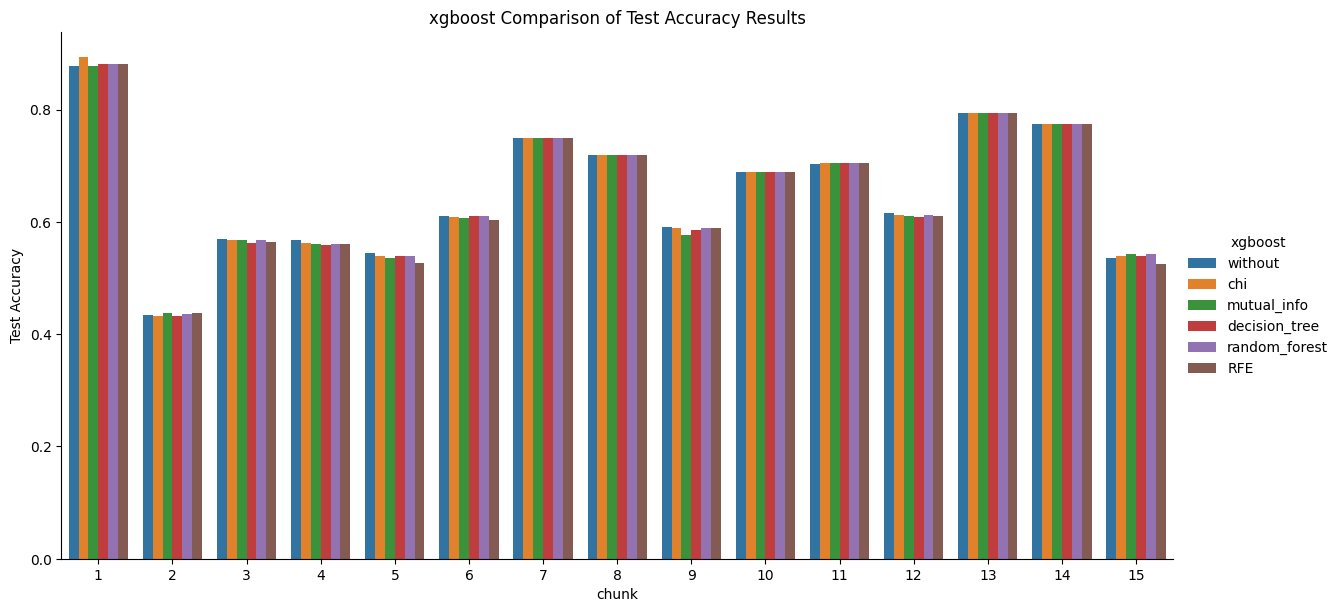

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
[0.8852459192276001, 0.44183602929115295, 0.5676966905593872, 0.5635925531387329, 0.5375856161117554, 0.6096156239509583, 0.7486659288406372, 0.719210684299469, 0.5840649604797363, 0.6892122626304626, 0.703972578048706, 0.6138233542442322, 0.7942692637443542, 0.7741159200668335, 0.5421836376190186]
[0.8852459192276001, 0.4266643226146698, 0.5679734349250793, 0.5620079636573792, 0.5291083455085754, 0.6083187460899353, 0.7485979795455933, 0.719210684299469, 0.5798344016075134, 0.6892256140708923, 0.703972578048706, 0.611615777015686, 0.7942692637443542, 0.7741159200668335, 0.522332489490509]
[0.8852459192276001, 0.4356692433357239, 0.5609630346298218, 0.5606135725975037, 0.5350331664085388, 0.6051291227340698, 0.7485979795455933, 0.719210684299469, 0.5765726566314697, 0.6892256140708923, 0.703972578048706, 0.6076295375823975, 0.7942692637443542, 0.7741159200668335, 0.5434243083000183]
[0.8852459192276001, 0

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


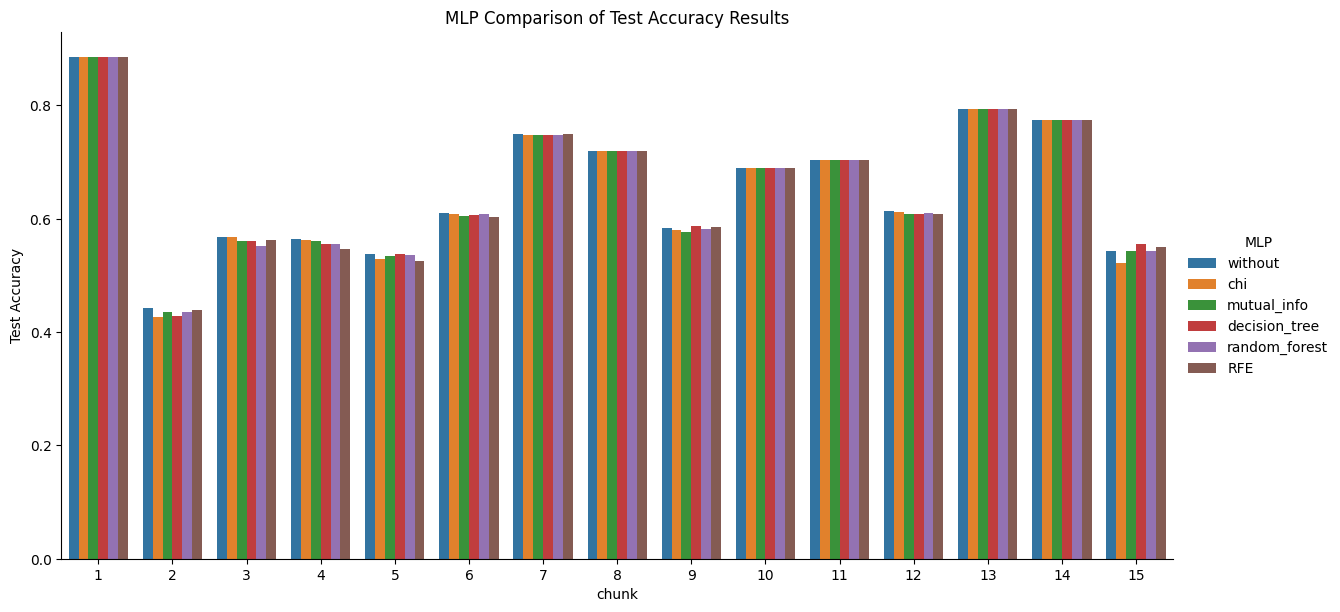

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_test_accuracy(results):
  # New dictionary
  new_res = {}
  # Convert the dictionary
  for meth, class_dict in results.items():
      for class_key, value in class_dict.items():
          if class_key not in new_res:
              new_res[class_key] = {}
          new_res[class_key][meth] = value
  results = new_res
  for classifier in results.keys():
    classifier_results=[]
    for method in results[classifier].keys():
      classifier_results.append(results[classifier][method]['test_acc'])


    # Data set labels
    data_set_labels = [f'{i+1}' for i in range(len(classifier_results[0]))]

    # Create a DataFrame
    df={}
    df['chunk'] = data_set_labels
    for method,r in zip(results[classifier].keys(),classifier_results):
      df[method]=r
    df = pd.DataFrame(df)

    # Melt the DataFrame to reshape it for catplot
    df_melted = pd.melt(df, id_vars='chunk', var_name=classifier, value_name='Test Accuracy')

    # Plot the catplot
    sns.catplot(data=df_melted, x='chunk', y='Test Accuracy', hue=classifier, kind='bar',height= 6,aspect=2)

    # Customize the plot
    plt.xlabel('chunk')
    plt.ylabel('Test Accuracy')
    plt.title(classifier +' Comparison of Test Accuracy Results')

    # Show the plot
    plt.show()
plot_test_accuracy(results)

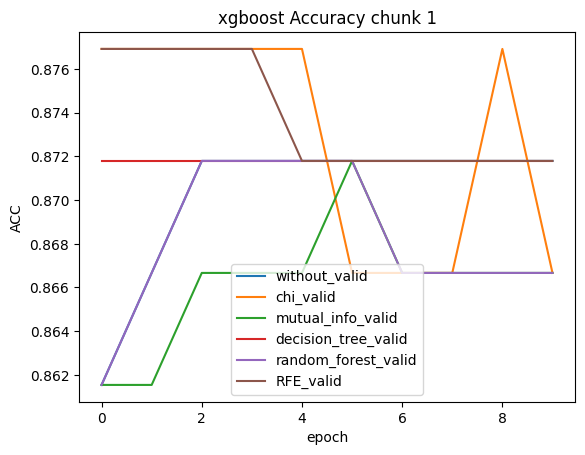

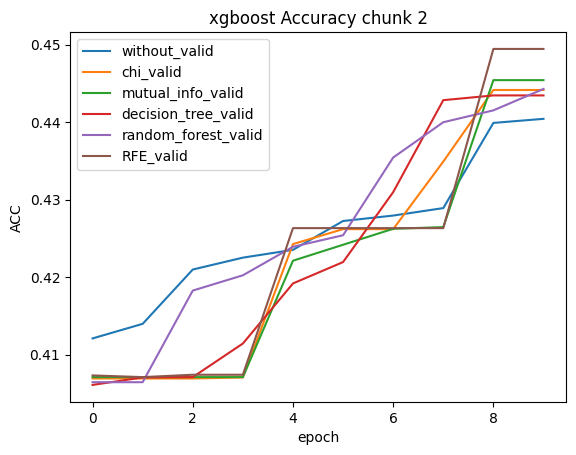

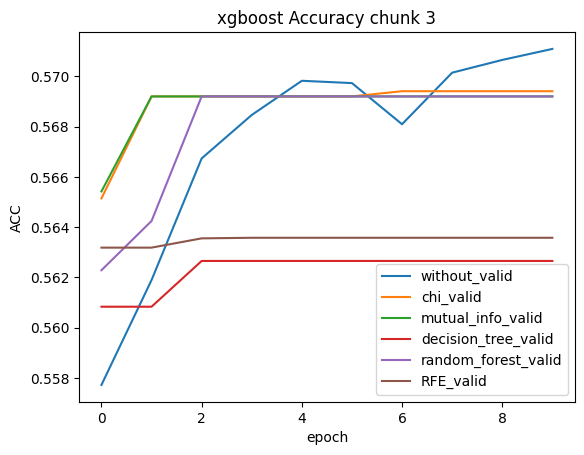

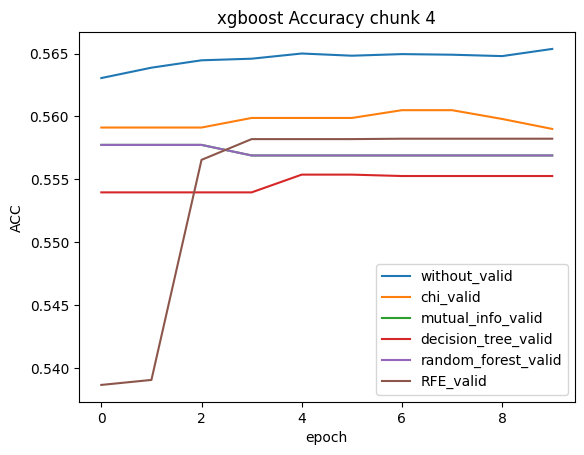

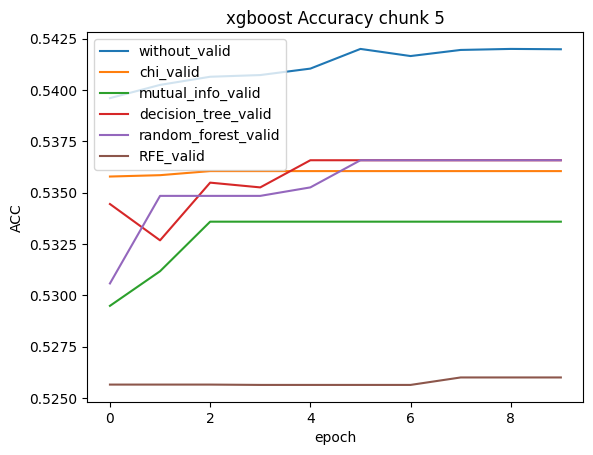

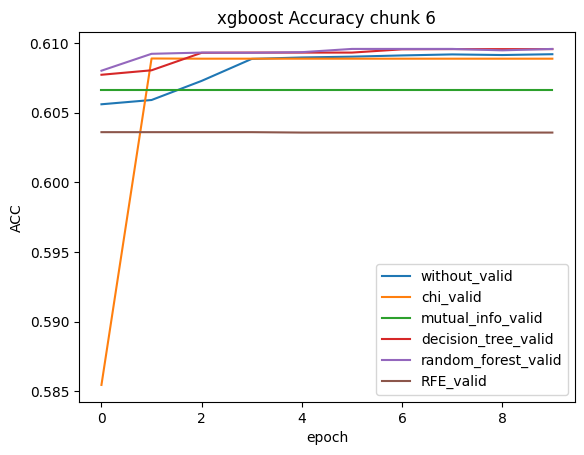

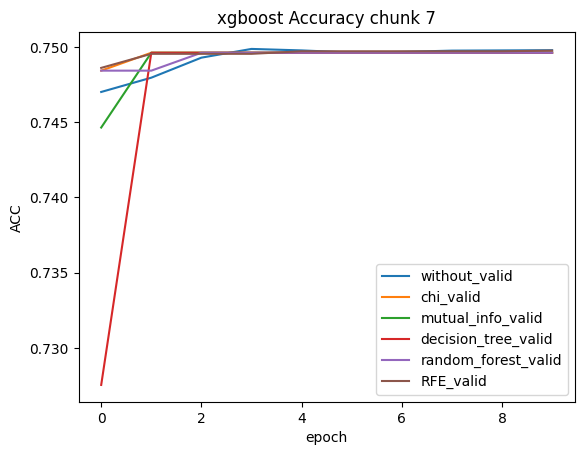

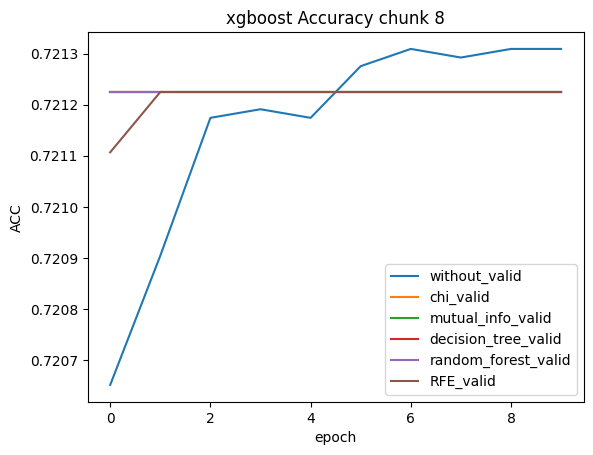

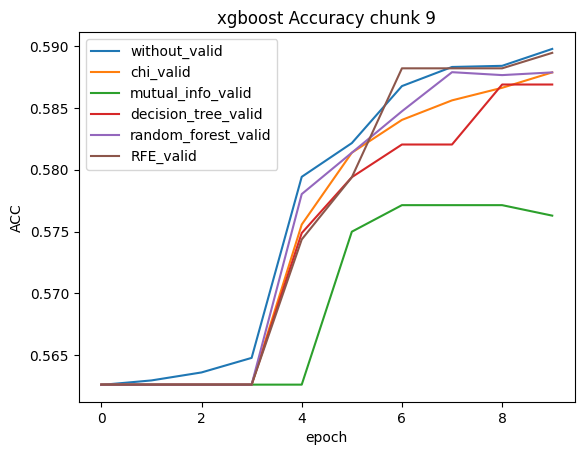

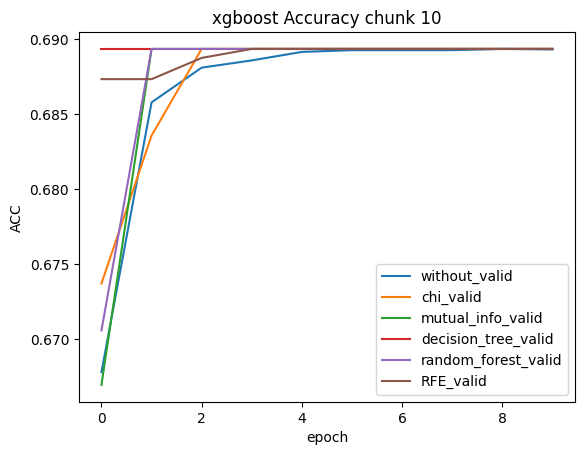

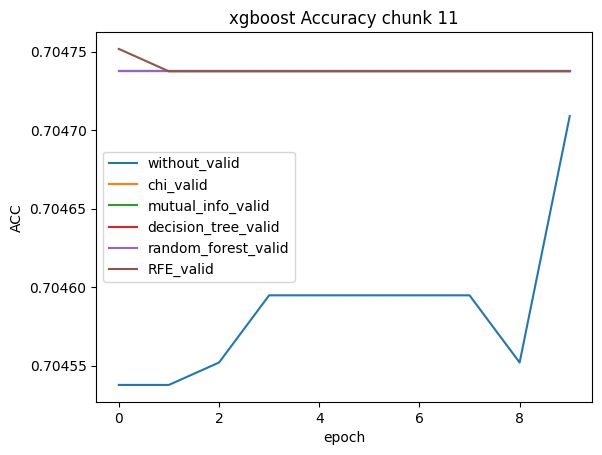

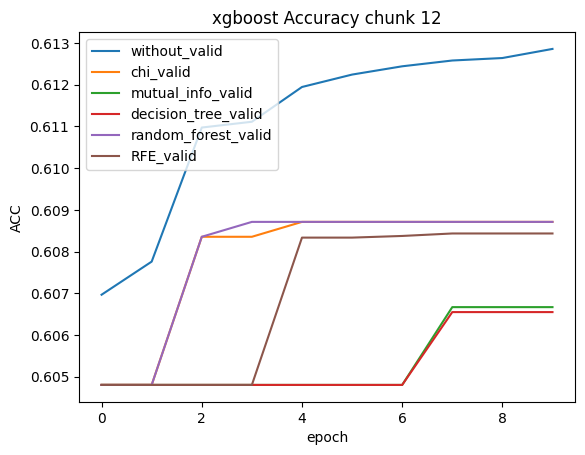

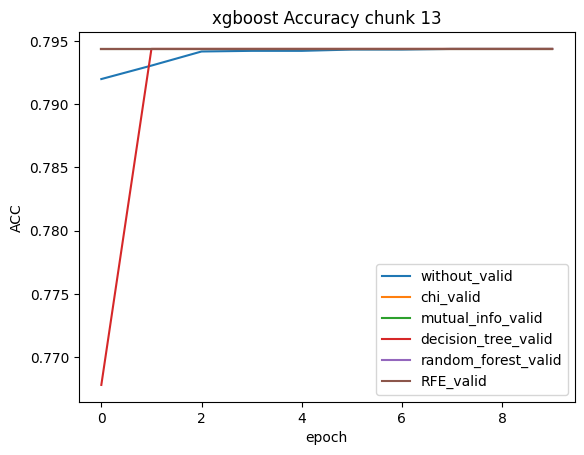

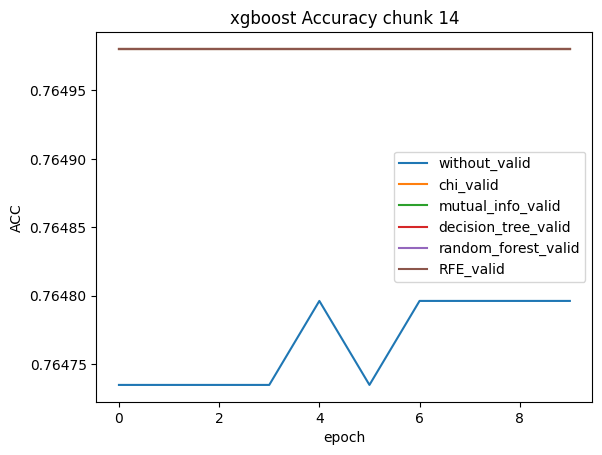

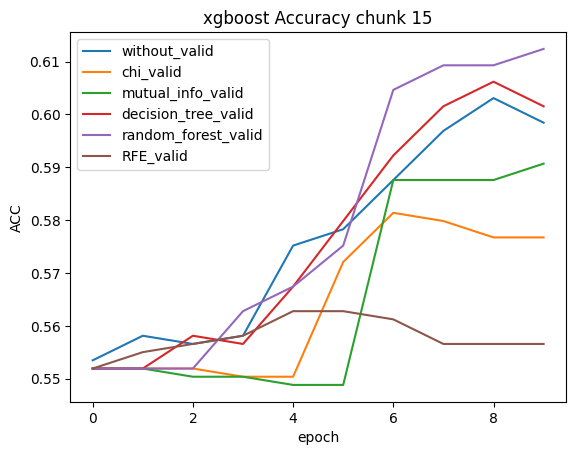

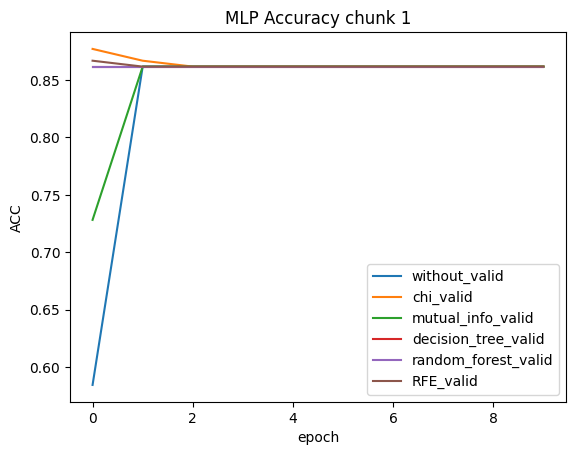

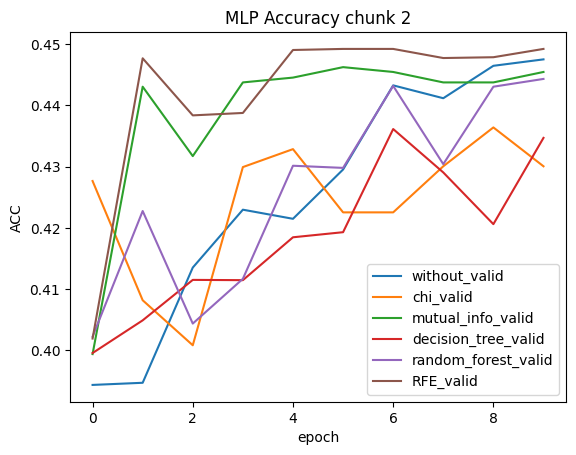

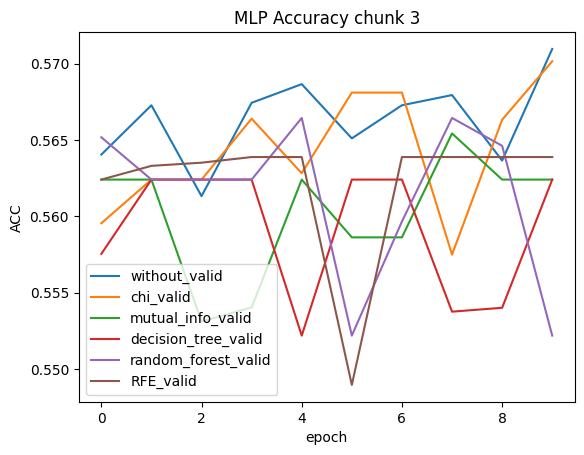

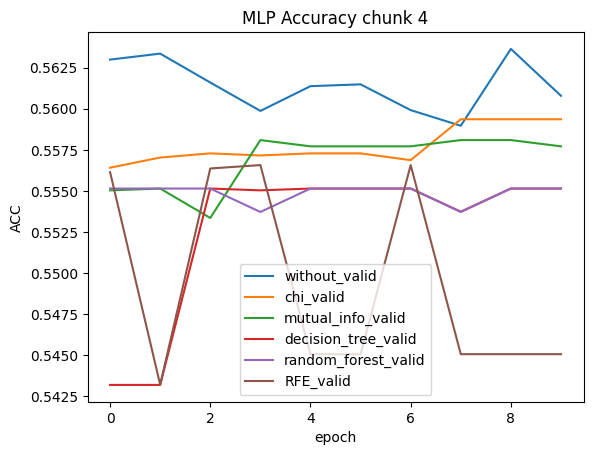

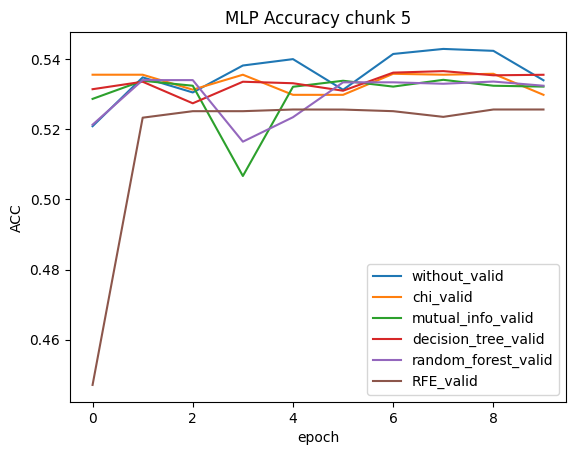

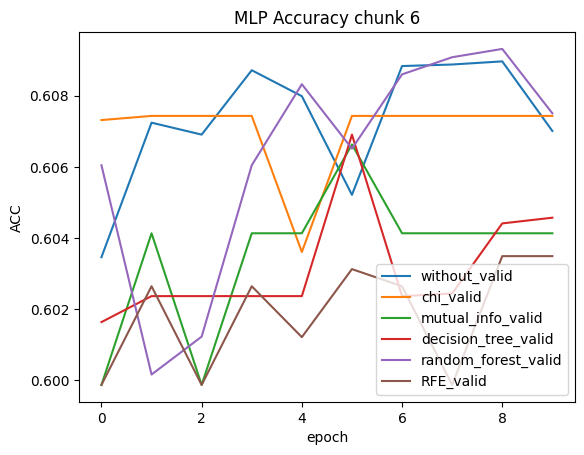

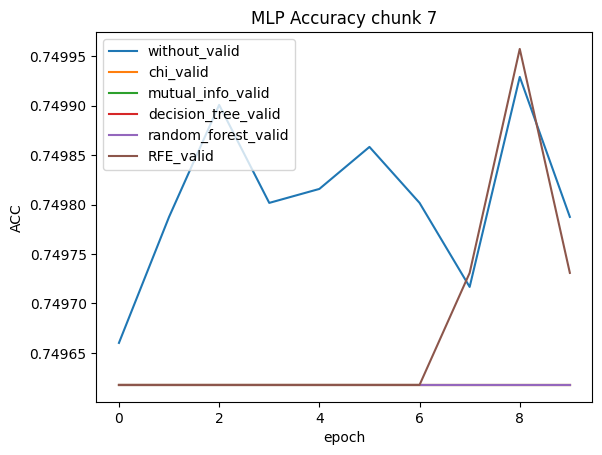

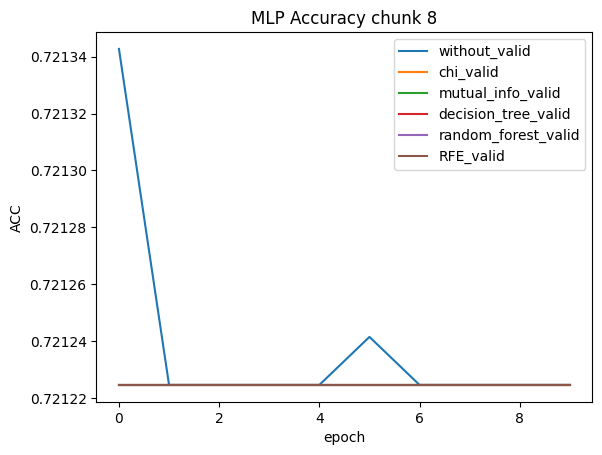

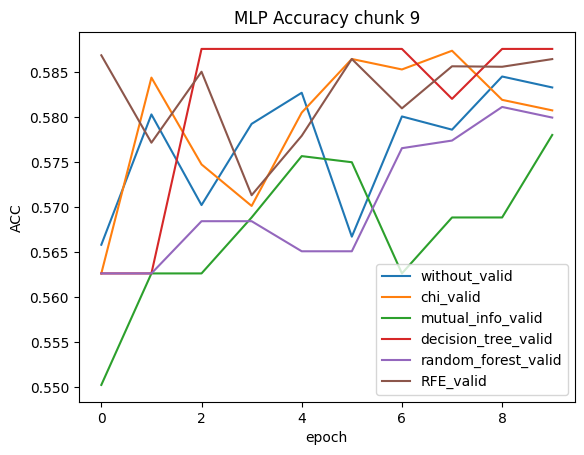

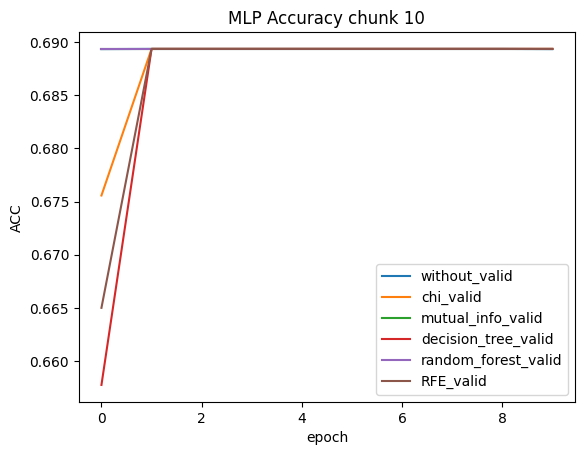

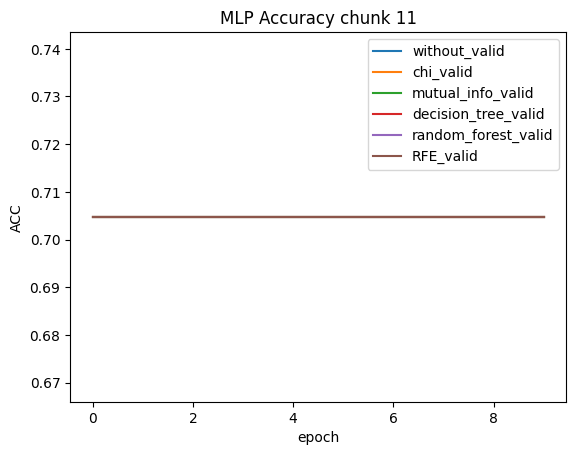

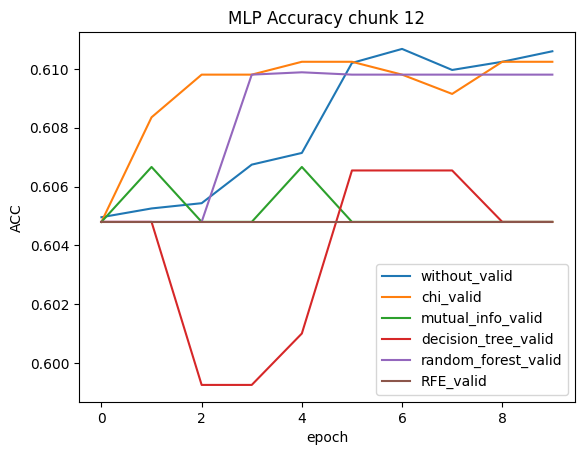

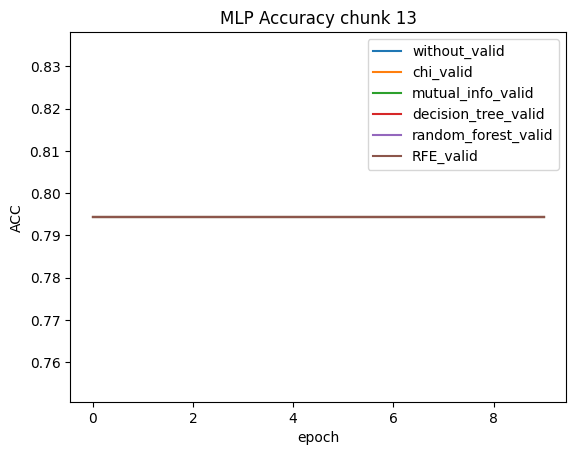

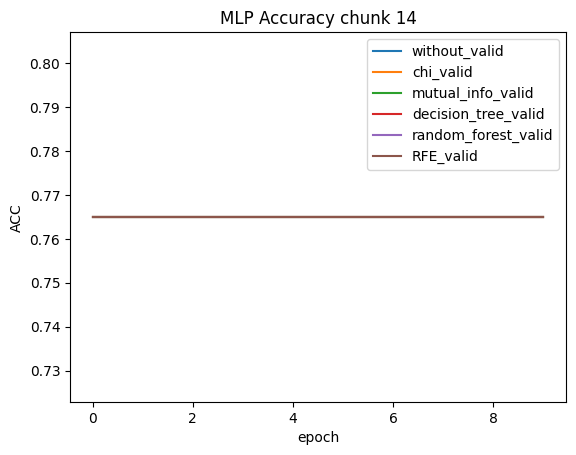

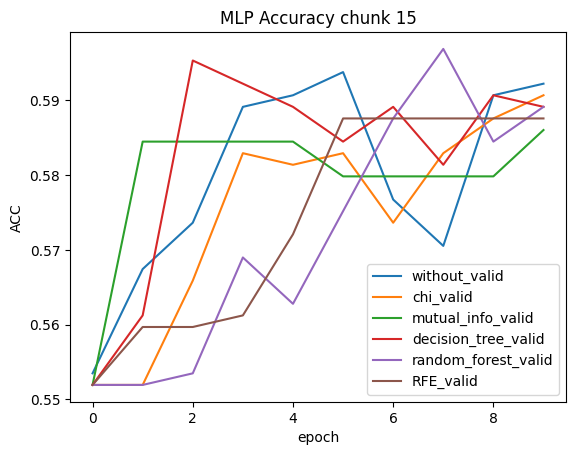

In [ ]:
def plot_valid_accuracy(results):
  # New dictionary
  new_res = {}
  # Convert the dictionary
  for meth, class_dict in results.items():
      for class_key, value in class_dict.items():
          if class_key not in new_res:
              new_res[class_key] = {}
          new_res[class_key][meth] = value
  results = new_res
  for classifier in results.keys():
    for chunk in range(15):
      fig, ax = plt.subplots()
      for method in results[classifier].keys():
        # classifier_results.append(results[classifier][method]['test_acc'])


        # ax.plot(results[classifier][method]['curve'][chunk][0], label=method+'_Train')
        ax.plot(results[classifier][method]['curves'][chunk][1], label=method+'_valid')
      ax.legend()
      plt.xlabel('epoch')
      plt.ylabel('ACC')
      plt.title(f'{classifier} Accuracy chunk {chunk+1}')
      # plt.savefig(f'ss {i+1}.jpg')
      plt.show()

plot_valid_accuracy(results)

In [ ]:
fs_results = {}
fs_results['chi'] = (chi_fs_df_list , chi_fs_masks)
fs_results['mutual_info'] = (mutual_info_fs_df_list , mutual_info_fs_masks)
fs_results['decision_tree'] = (decision_tree_fs_df_list , decision_tree_fs_masks)
fs_results['random_forest'] = (random_forest_fs_df_list , random_forest_fs_masks)
fs_results['RFE'] = (RFE_fs_df_list , RFE_fs_masks)

NameError: ignored

In [ ]:
fs_results.keys()

dict_keys(['chi', 'mutual_info', 'decision_tree', 'random_forest', 'RFE'])

# load results

In [ ]:
with open('accuracy_results.pkl','wb') as f:
  pickle.dump(results,f)

In [ ]:
with open('/content/drive/MyDrive/Covid files/fs_results.pkl','rb') as f:
  fs_results = pickle.load(f)
(chi_fs_df_list , chi_fs_masks) = fs_results['chi']
(mutual_info_fs_df_list , mutual_info_fs_masks) = fs_results['mutual_info']
(decision_tree_fs_df_list , decision_tree_fs_masks) = fs_results['decision_tree']
(random_forest_fs_df_list , random_forest_fs_masks) = fs_results['random_forest']
(RFE_fs_df_list , RFE_fs_masks) = fs_results['RFE']

In [ ]:
(chi_fs_df_list , chi_fs_masks) = fs_results['chi']
(mutual_info_fs_df_list , mutual_info_fs_masks) = fs_results['mutual_info']
(decision_tree_fs_df_list , decision_tree_fs_masks) = fs_results['decision_tree']
(random_forest_fs_df_list , random_forest_fs_masks) = fs_results['random_forest']
(RFE_fs_df_list , RFE_fs_masks) = fs_results['RFE']

In [ ]:
# !cp -r '/content/accuracy_results.pkl' '/content/drive/MyDrive/Covid files'